---
layout: default
title: "Deep Learning - RNN - Attention Model"
categories: deeplearning
permalink: /ML47/
order: 48
comments: true
---

In [5]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from mpl_flow import Flow

Populating the interactive namespace from numpy and matplotlib


# Attention model 
The attention model is an alternative to the encoder decoder architecture. 

### Attention model motivation
The intuition behind attention models is best introduced by looking at machine translation task for a long sentence. Suppose we have the input sentence

```
Jane s'est rendue en Afrique en septembre dernier, a apprécié la culture et a rencontré beaucoup de gens merveilluex; elle est revenue en parlant comment son voyage était merveilluex, et elle me tente d'y aller aussi.
```

And its reference translation

```
Jane went to Africa last Septembre, and enjoyed the culture and met many wonderful people; she came back raving about how wonderful the trip was, and is tempting me to go too.
```

An encoder-decoder model would take the whole sentence as input, encode it in a $n$-dimensional vector and then pass it to the decoder network to produce a translation. However, this is not how a human translator would proceed. A human translator is likely to translate the sentence one piece a time and proceed until completion. 

And so what we observe for encoder-decoder models is that they work well for short sentences but sentences longer than some tens of words, their performance decay. Attention models don't suffer from this performance decay (<a href="fig:attentionBLEU">figure below</a>).

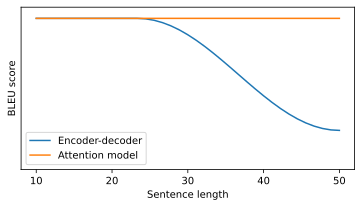

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
x = np.linspace(.5*np.pi, 1.5*np.pi, 25)
x2 = np.linspace(0, .5*np.pi, 25)
y = np.sin(x)
y2 = np.ones(x2.shape)

ax.plot(np.r_[x2, x], np.r_[y2, y], label='Encoder-decoder')
ax.plot(np.r_[x2, x], np.r_[y2, y2], label='Attention model')
ax.set_xticks(np.linspace(0, 1.5*np.pi, 5))
ax.set_xticklabels(np.arange(10, 60, 10))
ax.set_yticks([])
ax.set_ylabel('BLEU score')
ax.set_xlabel('Sentence length')
ax.set_ylim(-1.7, 1.2)
ax.legend();

## Attention model
Suppose we have an input sentence

```
Jane visite l'Afrique en septembre
```

And we use a bidirectional RNN (more commonly bidirectional GRU and bidirectional LSTM) to compute features on every word (<a href="#fig:attentionmodel">figure below</a>, bottom network). The notation for this bidirectional network is as follows: each step in the input sequence is $t^\prime$,  we denote with $\overrightarrow{a}^{\langle t^\prime \rangle}$ the forward occurrence and with  $\overleftarrow{a}^{\langle t^\prime \rangle}$ the backward occurrence of the network. For brevity we denote 

$$a^{\langle t^\prime \rangle} = \left(\overrightarrow{a}^{\langle t^\prime \rangle}, \overleftarrow{a}^{\langle t^\prime \rangle} \right)$$

Then we have a forward only RNN with state $s^{\langle t \rangle}$ that produces the output sequence $\hat{y}^{\langle t \rangle}$ (<a href="#fig:attentionmodel">figure below</a>, top network). Each step is fed a context $c^{\langle t \rangle}$ and the output from the previous step $\hat{y}^{\langle t-1 \rangle}$. The context of each step is fed the output from all the input activations $a^{\langle t^\prime \rangle}$ weighted by the **attention weights** $\alpha^{\langle t, t^\prime \rangle}$. The **attention weights** modulate how much the context of a step in the output sequence depends on the features ($a^{\langle t^\prime \rangle}$) of each time step in the input sequence. The context is in fact a weighted sum of the features of each time step in the input weighted by its attention weight.

$$
c^{\langle t \rangle} = \sum_{t^\prime}\alpha^{\langle t, t^\prime \rangle}a^{\langle t^\prime \rangle}
$$

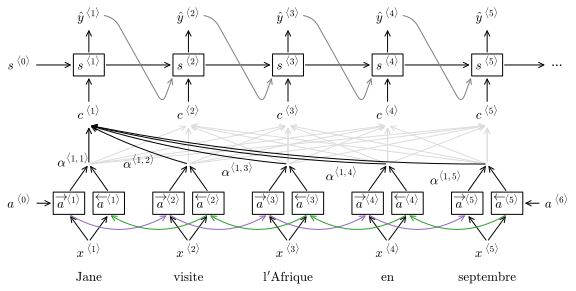

In [8]:
f = Flow(bbox=dict(boxstyle='square'), figsize=(10, 5), fontsize=13)
sentence = "Jane visite l'Afrique en septembre".split()
label = lambda b, i: '${}^{{ \\; \\langle {} \\rangle}}$'.format(b, i)
f.node('a0f', label=label('a', 0), bbox=dict(ec='none'))
for i, w in enumerate(sentence):
    f.node(f'a{i+1}f', startpoint=f'a{i}f', label=label('\\overrightarrow{{a}}', i+1), 
           connect=False if i > 0 else True, distance=1 if i > 0 else .5)
    f.node(f'a{i+1}b', distance=.4, startpoint=f'a{i+1}f', label=label('\\overleftarrow{{a}}', i+1), connect=False)
    f.node(f'a{i+1}', distance=(.2, 1), startpoint=f'a{i+1}f', label=label('x', i+1), travel='se', bbox=dict(ec='none'),
          edge_kwargs=dict(headport='n', tailport='s', arrowprops=dict(arrowstyle='->')))
    f.edge(f'a{i+1}', f'a{i+1}b', headport='s', tailport='n')
    f.node(f'w{i+1}', distance=.5, startpoint=f'a{i+1}', label=f'$\\mathrm{{{w}}}$', connect=False, travel='s',
          bbox=dict(ec='none'))
    f.node(f'o{i+1}', distance=(.2, 1), startpoint=f'a{i+1}f', label=' ', travel='ne', bbox=dict(ec='none'),
          edge_kwargs=dict(headport='s', tailport='n' ))
    f.edge(f'a{i+1}b', f'o{i+1}', headport='s', tailport='n')
    
    f.node(f'c{i+1}', label=label('c', i+1), travel='n', distance=.8, bbox=dict(ec='none'), 
                 edge_kwargs=dict(tailport='s', labelpos=(-2.5, 0.3), arrowprops=dict(ec='gainsboro')))
    f.node(f's{i+1}', label=label('s', i+1), travel='n', startpoint=f'c{i+1}')
    f.node(f'y{i+1}', label=label('\\hat{{y}}', i+1), travel='n', startpoint=f's{i+1}', bbox=dict(ec='none'))

    
    if i > 0:
        f.edge(f'a{i}f', f'a{i+1}f', tailport='s', headport='s', 
               arrowprops=dict(connectionstyle='arc3,rad=-.3', ec='C4'))
        f.edge(f'a{i+1}b', f'a{i}b', tailport='s', headport='s', 
               arrowprops=dict(connectionstyle='arc3,rad=.3', ec='C2'))
        f.edge(f's{i}', f's{i+1}')
        f.edge(f'y{i}', f's{i+1}', headport='sw', tailport='e', 
       arrowprops=dict(connectionstyle='arc,angleA=-110,angleB=-10,armA=30,armB=10,rad=10', 
                       shrinkA=2, shrinkB=0, ec='gray'))
            

f.node(f'a{len(sentence)+1}f', label=label('a', len(sentence)+1), bbox=dict(ec='none'), startpoint=f'a{len(sentence)}b',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='->')), distance=.5)
f.node('s0', label=label('s', 0), bbox=dict(ec='none'), startpoint=f's1',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='->')), distance=.7, travel='w')
f.node(f's{len(sentence)+1}', label='$\\cdots$', bbox=dict(ec='none'), startpoint=f's{len(sentence)}', distance=.7)


for i in range(len(sentence)):
    for j, xpos, ypos in zip(range(len(sentence)), 
                             [-2.5, 0.5, 0.75, 0.85, 0.9], 
                             [0, 0, -.2, -.3, -.4]
                            ):
        if i == 0:
            f.edge(f'o{j+1}', 'c1', tailport='s', headport='s', zorder=10,
                   label=f'$\\alpha^{{\\langle 1,{j+1} \\rangle}}$', 
                   arrowprops=dict(connectionstyle=f'arc3,rad={0.05 if j > 0 else 0}'), labelpos=(xpos, ypos))
        else:
            f.edge(f'o{j+1}', f'c{i+1}', tailport='s', headport='s', arrowprops=dict(ec='gainsboro'))


<i id="fig:attentionmodel">An attention model for a machine translation task. The input sequence is processed by a bi-directional network, which feeds into an forward network passing through a context layer. Each context layer is fed the activation (features) of all time-steps of the bi-directional network, weighted by a set of attention weights, which define how much each activation contributes to the output</i>

The attention weights satisfy the condition

$$
\begin{equation}
\sum_{t^\prime} \alpha^{\langle t, t^\prime \rangle} = 1
\end{equation} \label{eq:attwond} \tag{4}
$$

This means that the attention weights that modulate the contribution to the output step $t$ of each input steps $t^\prime$, sum to 1. The attention weights definition is built to satisfy $\eqref{eq:attwond}$:

$$
a ^{\langle t, t^\prime \rangle} = \frac{\exp \left( e^{\langle t, t^\prime \rangle} \right)}
{\sum_{t^\prime=1}^{T_x}\exp \left( e^{\langle t, t^\prime \rangle} \right)}
$$

The terms $e^{ \langle t, t^\prime \rangle}$ are usually computed by using a small neural network (usually with 1 hidden layer) that takes as input the state from the previous time step ($s^{\langle t-1 \rangle}$) and the features from the time step $t^\prime$, $a^{\langle t^\prime \rangle}$ (<a href="#fig:attentionweightnetwork">figure below</a>). The intuition behind this process is that if you want to know how much the current step $s^{\langle t \rangle}$ should pay to the activation $a^{\langle t^\prime \rangle}$, it should depend on the previous state  $s^{\langle t-1 \rangle}$ and on the activation itself.

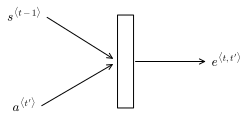

In [9]:
f = Flow(fontsize=13, figsize=(4, 2), bbox=dict(ec='none', boxstyle='square'))
f.node(label=r'$s^{\langle t-1 \rangle}$')
f.node(label=r'$a^{\langle t^\prime \rangle}$', travel='s', connect=False)
f.node(label='  \n\n\n\n\n', travel='ne', distance=(1, .5), bbox=dict(ec='k'), 
       edge_kwargs=dict(tailport='e', headport='w', arrowprops=dict(shrinkA=5)))
f.node(label=r'$e^{\langle t, t^\prime \rangle}$')
f.edge(1, 3, arrowprops=dict(shrinkA=5), tailport='e', headport='w');

<i id="fig:attentionweightnetwork">The network that determines the weighting function for state $s^{\langle t \rangle}$ is based on the previous state $s^{\langle t-1 \rangle}$  and on the features at $t^\prime$</i>

The neural network that sets the attention weights is trained as part of the whole model, so that the reference translations are themselves responsible of setting the function that determines the attention weights from the previous state in the output $s^{\langle t-1 \rangle}$ and the activation from each input time steps $a^{\langle t^\prime \rangle}$.

The downside of this architecture is that it has a quadratic cost. Given $T_x$ steps in the input and $T_y$ steps in the output, the attention parameters are $T_x \cdot T_y$.

Other than machine translation, the attention model has been applied to image captioning by [Xu et.al.2015](https://arxiv.org/pdf/1502.03044.pdf), who have shown hoe the caption can be generated by focusing (setting the attention) on part of a picture at a time.